# Projet 3 : développer à partir de l’expression de gènes (puce à ADN) un outil de diagnostic, capable de prédire plusieurs types de cancer.

Etudiants :
- Mattei Simon
- Mercado Pablo

## Introduction
### Un rappel sur ce qu'est le cancer
Le cancer est la prolifération de cellules anormales dans un tissu. Elles peuvent utiliser le système sanguin pour voyager et aller affecter d'autres tissus. Certains cancers sont d'origine génétique et ils existent plusieurs facteurs de risques (consommation excessive de tabac et alcool, exposition au soleil, obésité...). Manger une [pomme](https://pubmed.ncbi.nlm.nih.gov/23091184/), faites de l'exercice et manger sainement pour éviter le cancer!

Bien que l'âge ne soit pas la cause directe du cancer, on observe un taux d'incidence plus élevée chez les personnes agées. Avec le vieillissement de la population, la recherche du cancer est un domaine qui pourrait sauver beaucoup de vies.

### Types de cancer
On peut classer les [cancers](https://fr.wikipedia.org/wiki/Cancer) par les organes (et tissus) qu'ils touchent :
*    le cancer du sein
*    le cancer du côlon
*    le cancer du pancréas
*    le cancer de la prostate
*    le cancer du cerveau
*    le myélome multiple : cancer de la moelle osseuse
*    les leucémies
*    le sarcome de Kaposi : cancer des vaisseaux sanguins
*    les lymphomes
*    le cancer des testicules
*    le cancer des poumons
*    le cancer des reins
*    le cancer du foie

### Panel NCI60
Le dataset utilisé prend des [lignées cellulaires (cell line)](https://fr.wikipedia.org/wiki/Lign%C3%A9e_cellulaire_(m%C3%A9decine)), c-à-d des cellules pouvant théoriquement se diviser à l'infini.

In [1]:
import os
import numpy as np
import pylab as plt
%matplotlib inline
import pandas as pd

In [2]:
from Bio import Geo

def load_geo(myfile):
    handle = open(myfile)
    records = Geo.parse(handle)
    return records

records = load_geo('GDS4296.soft')

On extrait quelques informations sur le panel...

In [3]:
f = open("soft-info.txt", "w")

while True:
    try:
        nr = next(records)
        f.write(str(nr))
        f.write('\n---------------------- ENTITY_ATTRIBUTES:------------------------------\n')
        f.write(str(nr.entity_attributes))
    except StopIteration:
        print("done reading")
        break

done reading


Extrayons les données utiles: niveaux d'expressions des conditions et sources des conditions.

In [4]:
records = load_geo('GDS4296.soft')

# description of each condition (cell type)
id_cond_tissue = {}
diseases = set()

# loop over records
for r in records:
    rea = r.entity_attributes

    # condition for cell type/tissue/disease state
    if 'subset_dataset_id' in rea:
        sample_list = rea['subset_sample_id'].split(',')
        desc = rea['subset_description']

        if rea['subset_type'] == 'tissue':
            for sample in sample_list:
                id_cond_tissue[sample] = desc
                diseases.add(desc)

        # si l'on veut plus de détail sur la variété de cancer
        # e.g. https://fr.wikipedia.org/wiki/Astrocytome
        #if rea['subset_type'] == 'disease state':
            #for sample in sample_list:
                #id_cond_disease[sample] = desc
                #disease_with_details.add(desc)

    if 'dataset_table_begin' in rea:
        data = r.table_rows

# converts data to an array (more practical to handle)
data = np.array(data)
print(len(id_cond_tissue))

174


On désire connaître la proportion de cancer répertorié dans les échantillons. Histoire de vérifier qu'il y a suffisamment d'échantillons pour faire notre classificateur.

In [5]:
cancer_sample_count = {}
for cancer in diseases:
    cancer_sample_count[cancer] = 0
    for sample in id_cond_tissue:
        if cancer == id_cond_tissue[sample]:
            cancer_sample_count[cancer] = cancer_sample_count[cancer] + 1

total_sample = len(id_cond_tissue)

print("{: >20} {: >20}".format("Cancer location", '# échantillons'), '\tquantité (%)')
print('------------------------------------------------------------------')
for cancer in cancer_sample_count:
    print("{: >20} {: >20}".format(cancer, cancer_sample_count[cancer]), '\t', "{0:.2f}".format(cancer_sample_count[cancer]/total_sample*100))

     Cancer location       # échantillons 	quantité (%)
------------------------------------------------------------------
            prostate                    6 	 3.45
 non-small cell lung                   26 	 14.94
                 CNS                   18 	 10.34
            leukemia                   18 	 10.34
            melanoma                   26 	 14.94
              breast                   15 	 8.62
             ovarian                   21 	 12.07
               colon                   21 	 12.07
               renal                   23 	 13.22


Seul les échantillons de la prostate sont en petites quantités (3% de l'échantillonage).

Afin de mener nos recherches en étant objectif, on divise notre jeu de données en données de train et données de test:

In [6]:
import random
random.seed(5) #if you change this you will get different gene selection each time prob

# init dictionnary with disease - empty list
diseases_cond = {}
for disease in diseases:
    diseases_cond[disease] = []

# add every condition to dictionnary
for cond in id_cond_tissue:
    diseases_cond[id_cond_tissue[cond]].append(cond)

# shuffle conditions and add them to train/test conditions
test_conds = []
train_conds = []
for disease in diseases_cond:
    random.shuffle(diseases_cond[disease])
    idx_sep = int(len(diseases_cond[disease]) / 5) # 80/20%
    test_conds += diseases_cond[disease][:idx_sep]
    train_conds += diseases_cond[disease][idx_sep:]

# seperate data according to conditions
idx_test = []
for cond in test_conds:
    idx_test.append(data[0,:].tolist().index(cond))

idx_train = list(range(0,len(id_cond_tissue)+2))
[idx_train.remove(i) for i in idx_test]

data_test = data[:,idx_test]
data_train = data[:,idx_train]

print(np.shape(data_train))
print(np.shape(data_test))

(54676, 144)
(54676, 32)


On veut sélectionner les gènes pertinents dans notre jeu de train pour former notre classificateur. Affichons déjà les niveaux d'expression pour un gène aux travers des échantillons:

In [7]:
# cell types
cell_type = list(diseases) 
print('cell_type:\t'+str(cell_type))

# idx_cell_type will be used to re-order the columns of data as a function of cell_type
idx_cell_type = [0,1] # we don't want to re-order the first two columns (= gene name and identifier)

# colors will be used when plotting the data (each cell type has a corresponding color)
unique_colors = ['red','green','blue','cyan','magenta','yellow','purple','orange','lime']
colors_cell_type = [] 

# for every type in cell_type, find the corresponding colums in data and add them to idx_cell_type
for j,ct in enumerate(cell_type):
    elements_cell_type = [ i+2 for i,c in enumerate(data_train[0,2:]) if id_cond_tissue[c]==ct]
    idx_cell_type.extend(elements_cell_type)
    for _ in range(len(elements_cell_type)):
        colors_cell_type.append(unique_colors[j])
print('\nidx_cell_type:\t'+str(idx_cell_type))    
print('\ncolors_cell_type:\t'+str(colors_cell_type))

# re-order columns of data (= conditions) with idx_cell_type
data_train = data_train[:,idx_cell_type]

cell_type:	['prostate', 'non-small cell lung', 'CNS', 'leukemia', 'melanoma', 'breast', 'ovarian', 'colon', 'renal']

idx_cell_type:	[0, 1, 119, 120, 121, 122, 123, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 30, 31, 32, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 17, 18, 19, 20, 21, 22, 23, 24, 28, 29, 142, 143, 25, 26, 27, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83]

colors_cell_type:	['red', 'red', 'red', 'red', 'red', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'blue', 'blu

1372

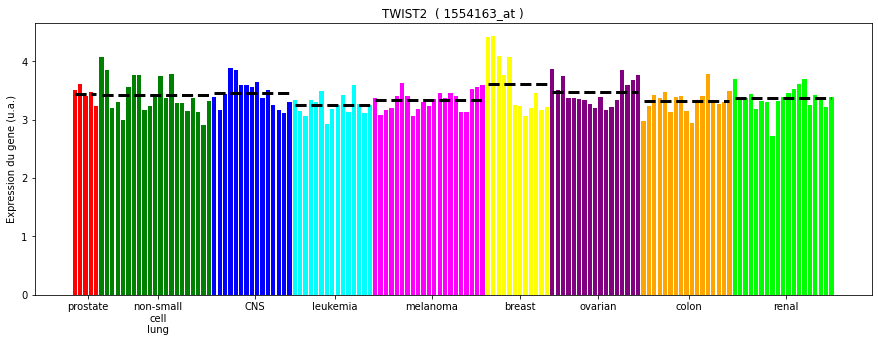

In [8]:
def mean_expressions(data,colors_cell_type):
    
    data_separated = np.zeros(len(unique_colors))
    for j,color in enumerate(unique_colors):
        data_separated[j] = np.nanmean([float(data[i]) for i,c in enumerate(colors_cell_type) if c==color])
        
    return data_separated

def plot_gene_expression_across_conditions(data,gene,cell_type,colors_cell_type):
    
    # find the line in data corresponding to our gene of interest and get the gene expression levels
    idx_gene = [i for i,x in enumerate(data[:,0]) if x==gene][0]
    data_to_show = (data_train[idx_gene,2:]).tolist() # remove the first two elements corresponding to gene name and identifier
    data_to_show = np.array(data_to_show,dtype=float) # convert to float
    
    # plot the data
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.bar(range(0,len(data_to_show)),data_to_show,color=colors_cell_type)
    plt.title(data_train[idx_gene,1]+'  ( '+data_train[idx_gene,0]+' )')

    # represent the mean gene expression in normal and cancer cells with a dashed line
    means = mean_expressions(data_to_show,colors_cell_type)
    first, last = (0,0)
    xticks = []
    for i,mean in enumerate(means):
        color = unique_colors[i]
        while last < len(colors_cell_type) and colors_cell_type[last] == color:
            last += 1
        xticks.append(first + ((last-first)/2))
        plt.hlines(mean,first,last - 1,linestyles='--',color='black',lw=3) # draw a line to show mean(expression of cancer cells)
        first = last
        
    ax.set_xticks(xticks)
    ax.set_xticklabels([ct.replace(' ','\n').replace('plus','+') for ct in cell_type])
    ax.set_ylabel('Expression du gene (u.a.)')
    
    return idx_gene

gene = '1554163_at'
plot_gene_expression_across_conditions(data_train,gene,cell_type,colors_cell_type)
# '1554165_at'

In [9]:
desired_profiles = {}
for disease in diseases:
    desired_profiles[disease] = [1 if id_cond_tissue[s]==disease else 0 for s in data_train[0,2:]]
    
print(desired_profiles['breast'])
print(desired_profiles['renal'])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [10]:
def pearson_genes(data,desired_profile,show_plot=1):

    import scipy.stats as ss

    correl = [] # contains the correlation for each gene
    correl_p  = [] # for now, do not try to understand what correl_p is...
    
    # loop over genes
    for i in range(np.shape(data)[0]-1): # do not consider first line of data (=header)
        
        gene_expression = data[i+1,2:] # do not consider first two columns (= gene identifiers)
        gene_expression = np.array(gene_expression,dtype=float) # convert to float
        
        pearson_corr = ss.pearsonr(gene_expression,desired_profile) # calculate Pearson correlation
        correl.append(pearson_corr[0])
        correl_p.append(pearson_corr[1]) # forget about this for now...
        
    correl = np.array(correl,dtype=float) # convert to array... easier to manipulate
    
    # plot correlation values
    if show_plot:
        fig = plt.figure()
        plt.plot(correl,'bo')
        plt.ylim([-1,1])
        plt.xlim([0,len(correl)])
        plt.xlabel('Gene index')
        plt.ylabel('Pearson correlation')
        plt.show()
        
        plt.figure()
        plt.hist(correl)
        plt.xlabel('Pearson correlation')
        plt.ylabel('Counts')
        plt.xlim([-1,1])
        plt.show()

    return (correl,correl_p)

In [11]:
correlations = {}
for disease in diseases:
    correlations[disease] = pearson_genes(data_train,desired_profiles[disease],show_plot=False)[0]

In [12]:
print("Correlation values for breast : ", correlations['breast'])

Correlation values for breast :  [ 0.19341484 -0.08758506 -0.00293082 ...  0.07910521  0.00492325
 -0.06370762]


Comparaison à des valeurs aléatoires et première sélection de gènes pour chaque maladie

In [13]:
def shuffle_data(data):
    
    from random import shuffle
    
    # get shuffled columns indexes
    shuffled_idx = list(range(2,np.shape(data)[1])) # ! do not shuffle the first two colums (= gene identifiers)
    shuffle(shuffled_idx) # shuffled_idx is now shuffled
    shuffled_idx.insert(0,0)
    shuffled_idx.insert(1,1)

    # use shuffled_idx to randomize the columns of data
    data_random = data[:,shuffled_idx]
    data_random[0,:] = data[0,:] # put label conditons on top again

    return data_random

In [14]:
def compare_to_random_data(disease, show_plot=False):
    data_random = shuffle_data(data_train)
    corr_random = pearson_genes(data_random,desired_profiles[disease],show_plot=False)[0]

    if show_plot:
        corr_normal = correlations[disease]
        plt.figure()
        plt.title(f"First random generation for {disease}")
        plt.hist(corr_normal,label="normal")
        plt.hist(corr_random,label="random")
        plt.legend()
        plt.xlabel('Pearson correlation')
        plt.ylabel('Counts')
        plt.xlim([-1,1])
        plt.show()
    
    return corr_random

In [15]:
print(compare_to_random_data('breast', show_plot=False))

[ 0.00898582  0.03553567 -0.038865   ...  0.02773908 -0.01708302
 -0.13901974]


# Cette cellule prend ~20minutes
On execute ici 10 fois la correlation sur des données aléatoires, pour chaque gène, pour chaque maladie, et on les sauve dans un fichier txt.
Pour chaque première génération, on montre le résultat comparé à la correlation normale

In [16]:
N_genes = np.shape(data_train)[0]-1

In [17]:
# correlations_random = {}
# N_genes = np.shape(data_train)[0]-1
# n_randoms = 10

# #create n_random rows for generating correlations n_random times, for each gene, for each disease
# for disease in diseases:
#     correlations_random[disease] = np.zeros((n_randoms, N_genes))
    
# print(correlations_random['breast'].shape)

# for disease in diseases:
#     for i in range(n_randoms):
#         if i == 0:
#             correlations_random[disease][i] = compare_to_random_data(disease, show_plot = True)
#         else:
#             correlations_random[disease][i] = compare_to_random_data(disease)
#     np.savetxt(f'correlations/{disease}.txt', correlations_random[disease], fmt='%f')

Calcul de la p-value pour chaque gène pour chaque maladie

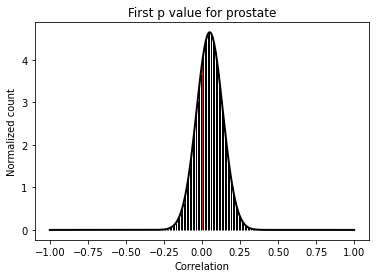

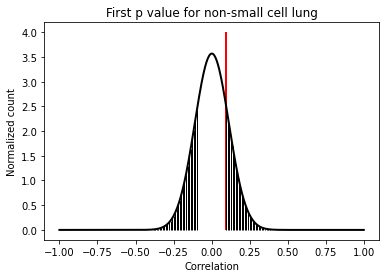

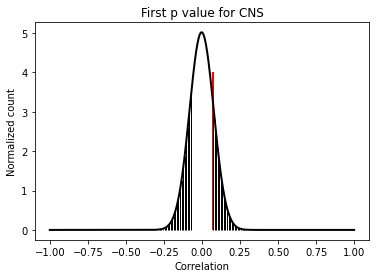

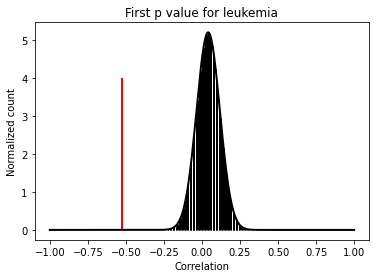

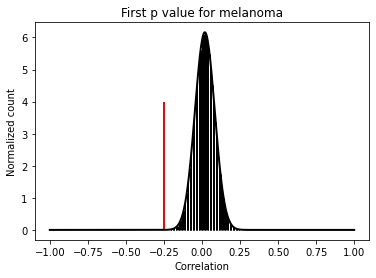

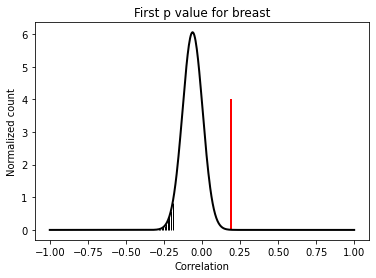

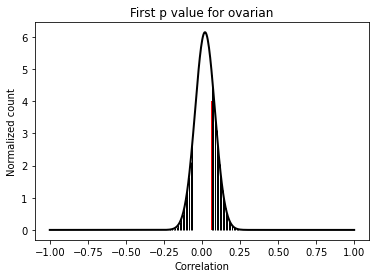

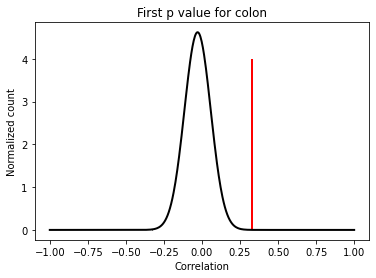

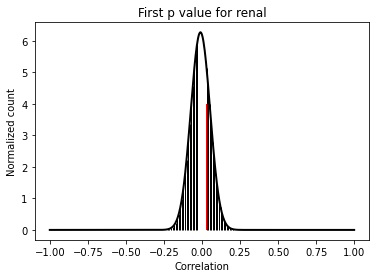

In [18]:
from scipy.stats import norm

pval_correls = {} # p-values 

for disease in diseases:
    pval_correls[disease] = []
    correlation_random = np.loadtxt(f'correlations/{disease}.txt', dtype=float)
    for idx in range(0,N_genes):

        # random correlation: calculate mean and standard deviation
        random_correlations = correlation_random[:,idx]
        mean_random = np.mean(random_correlations)
        std_random = np.std(random_correlations)

        # observed correlation
        observed_correlation = correlations[disease][idx]

        # cdf: cumulative distribution function = integral of the gaussian distribution from -inf to observed_correlation
        cdf = norm.cdf(observed_correlation,loc=mean_random,scale=std_random)
        if cdf >= 0.5:
            p = 1 - cdf
        else:
            p = cdf
        pval_correls[disease].append(2*p) # factor 2 because correlations can take both positive and negative values

        # show p-value visually for the first gene (p-value = area of black hatched regions under the curve)
        if idx==0:
            plt.figure()
            plt.title(f"First p value for {disease}")
            xx = np.linspace(-1,1,500)
            plt.plot(xx,norm.pdf(xx,loc=mean_random,scale=std_random),'k-',lw=2)
            plt.vlines(correlations[disease][idx],0,4 ,'r',lw=2)
            for j in np.linspace(observed_correlation,1,int(100*(1-observed_correlation))):
                plt.vlines(j,0,norm.pdf(j,loc=mean_random,scale=std_random),'k',lw=1)
            for j in np.linspace(-1,-observed_correlation,int(100*(1-observed_correlation))):
                plt.vlines(j,0,norm.pdf(j,loc=mean_random,scale=std_random),'k',lw=1)
            plt.xlabel('Correlation')
            plt.ylabel('Normalized count')
            plt.show()

avec un FDR de 5%, i.e. parmi les gènes identifiés comme significatifs, seuls 5% d'entre eux risquent d'être de faux positifs

In [60]:
for disease in diseases :
    print(disease)

prostate
non-small cell lung
CNS
leukemia
melanoma
breast
ovarian
colon
renal


-log10(p-value FDR) = 5.250171623408248



C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


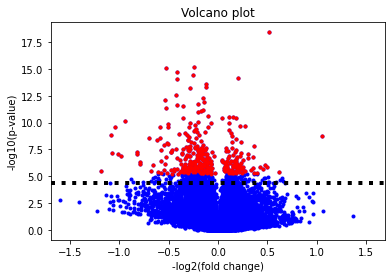

353 significant genes found for prostate with correlation (after p-value correction): 

-log10(p-value FDR) = 6.95667806313124



C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


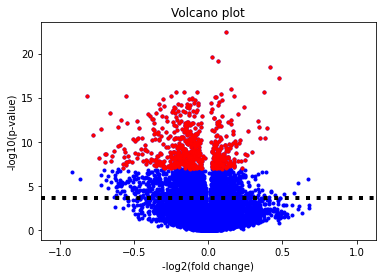

701 significant genes found for non-small cell lung with correlation (after p-value correction): 



C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


-log10(p-value FDR) = 8.837645483695676



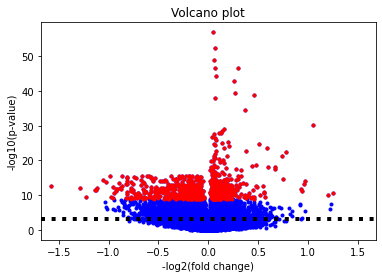

918 significant genes found for CNS with correlation (after p-value correction): 

-log10(p-value FDR) = 22.724339007678026



C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


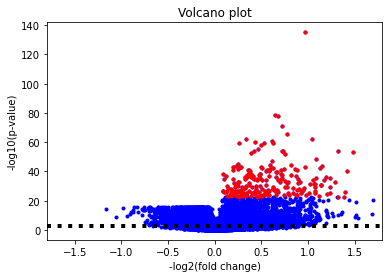

1250 significant genes found for leukemia with correlation (after p-value correction): 



C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


-log10(p-value FDR) = 14.861523361317285



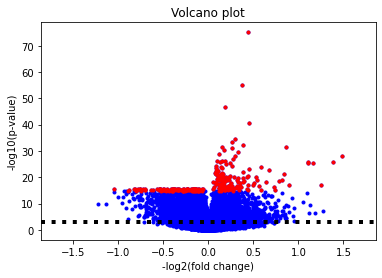

921 significant genes found for melanoma with correlation (after p-value correction): 

-log10(p-value FDR) = 5.959950468349846



C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


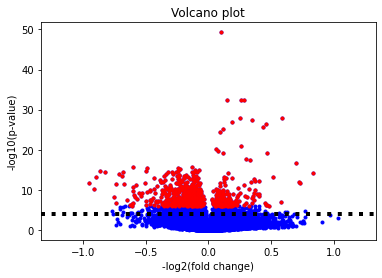

688 significant genes found for breast with correlation (after p-value correction): 

-log10(p-value FDR) = 6.906476584876656



C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


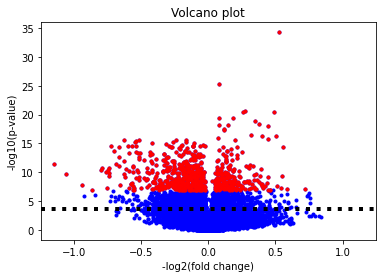

778 significant genes found for ovarian with correlation (after p-value correction): 

-log10(p-value FDR) = 10.845767763465693



C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


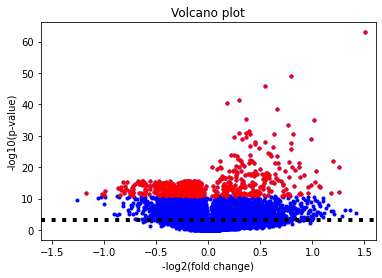

906 significant genes found for colon with correlation (after p-value correction): 

-log10(p-value FDR) = 10.891046259059477



C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


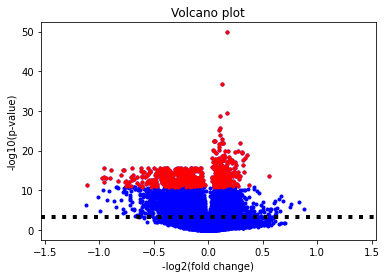

808 significant genes found for renal with correlation (after p-value correction): 



In [76]:
qval_corr = {} #0.05 # default is 0.05
# 0.005 -> 97% for 2 disease
# 0.001 -> non-small cell lung doesnt select any gene

qval_corr['breast'] = 0.001 # 8.3E-4 594,660,921
qval_corr['renal'] = 0.00000001 # 6.00E-11 560
qval_corr['leukemia'] = 0.00000000000000000001 # 889 1066
qval_corr['melanoma'] = 0.000000000001 # 634 np.nextafter(0, 1) == 5E-324
qval_corr['ovarian'] = 0.0001 # 2.02E-5 551
qval_corr['non-small cell lung'] = 0.0001 # 8.6E-6 317 8.7E-6 628
qval_corr['CNS'] = 0.000001 # 1.68E-8 561,638
qval_corr['prostate'] = 0.01 # 1.9E-2 737,457
qval_corr['colon'] = 0.00000001 # 2.1E-11 619

import stats
idx_sg_corrs = {} #significative genes

for disease in diseases:
    # stats.py has default qval = 0.05
    fdr_pval = stats.fdr_correction(pval_correls[disease], qval_corr[disease]) # default qval is 0.05
    print('-log10(p-value FDR) = '+str(-np.log10(fdr_pval))+'\n')

    # idx of genes with p-value < fdr_pval
    idx_sg_corrs[disease] = np.array([i for i,p in enumerate(pval_correls[disease]) if p<fdr_pval])

    # Volcano plot that shows significant genes in red
    stats.volcano_plot(data_train[1:,2:],desired_profiles[disease],pval=pval_correls[disease],idx=idx_sg_corrs[disease])

    # print how many significant genes were found
    print(str(len(idx_sg_corrs[disease]))
          + f' significant genes found for {disease} with correlation (after p-value correction): \n'
          #+ str(data_train[idx_sg_corrs[disease]+1,1])
          )

# T-Test

1

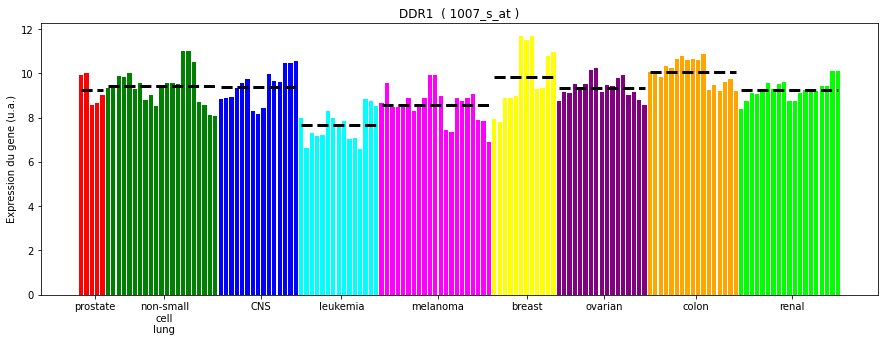

In [20]:
plot_gene_expression_across_conditions(data_train,'1007_s_at',cell_type,colors_cell_type)

On peut voir ici que DDR1 a été montré comme significatif avec la moyenne générale, ce qui est correct (c'est la moyenne la plus haute). Par contre ce n'est pas assez pour différencier d'autres groupes, du coup le T-Test c'est bien. Ce gène a aussi été choisi pour la leucémie, ce qui fait du sens.

**Note**: Cette cellule prend ~20 minutes, j'ai tout sauvé dans les fichiers pval_ct/disease.txt

In [21]:
# from scipy.stats import ttest_ind

# pval_ct = {}

# for disease in diseases:
#     print(f"starting {disease}...")
#     idx_disease = [i+2 for i,c in enumerate(data_train[0,2:]) if id_cond_tissue[c]==disease] # column idx

#     # perform t-test between cancer cell type and each normal cell type
#     pval_ct[disease] = [] # p-value across cell types
#     for k,ct in enumerate(cell_type[:-1]):   

#         idx_normal = [i+2 for i,c in enumerate(data_train[0,2:]) if id_cond_tissue[c]!=disease] # column idx corresponding to a cell type

#         pval = []
#         for g in range(1,N_genes+1): # loop over genes

#             normal = np.array(data_train[g,idx_normal],dtype=float)
#             curr_disease = np.array(data_train[g,idx_disease],dtype=float)
#             ttest = ttest_ind(normal,curr_disease,equal_var=False) # return t-value and its associated p-value
#             pval.append(ttest[1])
#         pval_ct[disease].append(pval)
#     np.savetxt(f'pval_ct/{disease}.txt', pval_ct[disease], fmt='%f')

In [75]:
import importlib

qval = {}

qval['colon'] = 0.0005
qval['melanoma'] = 0.0002
qval['ovarian'] = 0.01
qval['renal'] = 0.001
qval['leukemia'] = 0.0005
qval['breast'] = 0.01
qval['non-small cell lung'] = 0.005
qval['CNS'] = 0.0005
qval['prostate'] = 0.001

idx_sg_ttests = {}

for disease in diseases:
    pval_ct = np.loadtxt(f'pval_ct/{disease}.txt', dtype=float)
    
    # fdr correction
    importlib.reload(stats)
    fdr_pval = [stats.fdr_correction(pval_ct[ct], qval[disease]) for ct in range(len(pval_ct))]

    # keep genes for which the t-test p-value is smaller than the fdr-corrected threshold (fdr_pval)
    idx_sg_ttest = []
    for i in range(N_genes):
        significant = [1 if pval_ct[ct][i]<fdr_pval[ct] else 0 for ct in range(len(pval_ct))]
        if sum(significant)==8:
            idx_sg_ttest.append(i)
    
    idx_sg_ttests[disease] = idx_sg_ttest
            
    print(f'Nombre de gène significatifs pour {disease}: {len(idx_sg_ttest)}')

Nombre de gène significatifs pour prostate: 1219
Nombre de gène significatifs pour non-small cell lung: 615
Nombre de gène significatifs pour CNS: 2773
Nombre de gène significatifs pour leukemia: 2920
Nombre de gène significatifs pour melanoma: 3040
Nombre de gène significatifs pour breast: 1079
Nombre de gène significatifs pour ovarian: 1185
Nombre de gène significatifs pour colon: 3099
Nombre de gène significatifs pour renal: 1986


Nombre de gène significatifs combinés pour prostate: 20
LISTE FINALE DE GENES POUR prostate:
'IVD' 'MZT1' 'SAR1B' 'ZIC2' 'HSPA4' '227907_at' 'TUBA1B' 'CTC1' 'TBL1X'
 'ACTA2' 'BMI1' 'YBEY' 'AFG3L2' 'TUBA1B' 'ANXA11' 'TOR3A' 'TOR3A'
 'ZSWIM8-AS1' 'PLGRKT' 'AF308291'


C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)


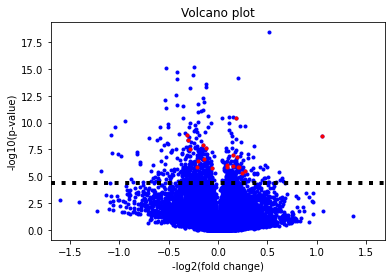



Nombre de gène significatifs combinés pour non-small cell lung: 74
LISTE FINALE DE GENES POUR non-small cell lung:
'CAST' 'LYPLAL1' 'HSPA1B' 'CABYR' 'RPS6KA6' 'AI923713' 'PIR' 'PSMD11'
 'COL4A5' 'RHBDD2' 'SYNM' 'SNX12' 'KHSRP' 'LRP10' 'SFXN1' 'SLC46A1'
 'CABYR' 'OPN3' 'SMARCA4' 'PSMB5' 'AK022197' 'PIK3R1' 'SNAPC5' 'GPC1'
 'FLOT2' 'IL13RA1' 'ID1' 'MINPP1' 'TYSND1' 'SMG1' 'TMEM106B' 'EGR1'
 'FAM177A1' 'DTD2' 'PNKD' 'G6PC3' 'STK32A' 'DLGAP1-AS1' 'PCYOX1' 'H2AFJ'
 'PCDHA1' 'ADSSL1' 'PCDHA1' 'LOC100506314' 'LPCAT3' 'ANK2' 'ABHD15'
 'EXOC6B' 'KSR1' 'LYST' 'SMARCA4' 'PCDHA1' 'RHBDD2' 'AP4S1' 'BHLHB9'
 'AFF3' 'AK055960' 'ZBED5-AS1' 'HEXIM1' 'SPR' 'SNAPC5' 'NAP1L2' 'PDS5B'
 'LINC01420' 'SLC35E3' 'PTGS2' 'XPR1' 'CHD8' 'MAPK9' 'OPN3' 'MAPK9'
 'RDH14' 'SIRT3' 'PPAP2C'


C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


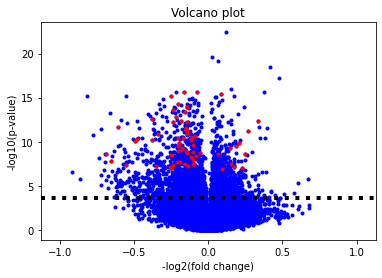



Nombre de gène significatifs combinés pour CNS: 338
LISTE FINALE DE GENES POUR CNS:
'FKBP14' 'PHTF1' 'PGAP2' 'ZC3H8' 'CALD1' 'HLA-A' 'RPL29' 'LSM10' 'RPS21'
 'GLIPR2' 'TRMT5' 'RAP1GAP2' 'SPRYD4' 'ADAM12' 'COX15' 'TACC1' 'HLA-B'
 'CLNS1A' 'ATP5C1' 'FBRSL1' 'DLL3' 'COX15' 'TENM2' 'LOX' 'RPL31' 'COL12A1'
 'LOC100130987' 'C11orf48' 'HADHB' 'SGCB' 'SGCB' 'HOOK1' 'VRK2' 'TOP1MT'
 'BE620258' 'MTIF2' 'RANBP17' 'DDR2' 'PDGFRA' 'RAB11FIP1' 'GNA12' 'RPS29'
 'MAP1LC3A' 'ZYG11B' 'KIF1B' 'DNAH14' 'MARCKS' 'ESRRA' 'DNAAF3' 'EIF3L'
 'TSEN2' 'SMPD1' 'ZNF24' 'ENOSF1' 'E2F7' 'RPL3' 'PAIP2B' 'WNK3' 'RNF44'
 'PTN' 'PTN' 'CCDC126' 'LRPPRC' 'FAM69A' 'SEC22C' 'GLTSCR2' 'LAYN'
 'CCDC126' 'ARID4A' 'COL5A1' 'TTLL7' 'SLFN12' 'RPL3' 'MRPS25' 'MAP1B'
 'LINC00910' 'LRPPRC' 'STAT6' 'STAT6' 'ELL2' 'PLEKHG4' 'ADAM12' 'CHD7'
 'PRSS12' 'WNK3' 'PTN' 'GLTSCR2' 'ARSJ' 'PPP6R3' 'VAMP4' 'MAP7D1' 'PRAF2'
 'PRSS12' 'CALD1' 'SEC61G' 'CCNB1IP1' 'ZFAS1' 'RPP38' 'RPL3' 'ULBP2'
 'SLC35D1' 'RPL41' 'HLA-A' 'PCDHGA3' 'RPS7' 'PNPLA4' 

C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


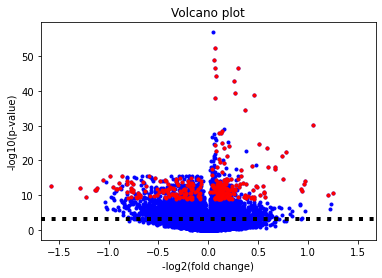



Nombre de gène significatifs combinés pour leukemia: 260
LISTE FINALE DE GENES POUR leukemia:
'RND3' 'ERBB2' 'PTK2' 'DAG1' 'GPX8' 'GPX8' 'GNA11' 'PPAP2B' 'SH3RF1'
 'EMP2' 'EMP2' 'MYO1C' 'ARHGDIB' 'VAV2' 'PLCB4' 'PPAP2B' 'KIF21B' 'PARVA'
 'KLHL6' 'SEPT6' 'ARHGAP4' 'ZNF426' 'WAS' 'KANK2' 'WDR45B' 'LOC100505812'
 'ICAM3' 'CD53' 'CORO1A' 'LRCH4' '1556657_at' '1556658_a_at' 'DEF6' 'LSM5'
 'TSC22D4' 'IKZF1' 'CELF2' 'GNAI1' 'KIAA1549' 'DYNC1LI2' 'LZTS2'
 'AI681888' 'EMP2' 'LCP2' 'GNA11' 'TSPAN6' 'TSPAN6' 'ZNF708' 'ADRBK1'
 'SBF2' 'LOC100506828' 'PFN2' 'SLC6A8' 'AU146924' 'PLEKHG3' 'SFMBT2'
 'SH3D19' 'CTTNBP2NL' 'HCLS1' 'IQGAP2' 'SRSF4' 'AA749202' 'ERRFI1' 'ZNF92'
 'PSD4' 'ELMO1' 'CEP57' 'RAPH1' 'RAPH1' 'RAPH1' 'AKNA' 'YIPF6' 'YIPF6'
 'EPHA2' 'PLEKHA1' 'IKZF1' 'IKZF1' 'ZNF267' 'ZNF22' 'ZNF22' 'MANBAL'
 'ING3' 'KIF3B' 'SCRN1' 'MYO10' 'MET' 'AMOTL2' 'CORO7' 'MYO1B' 'MYO1B'
 'SCLT1' 'DIAPH1' 'MAPRE2' 'PLEKHA1' 'ADCY6' 'MYOF' 'ING3' 'BU681135'
 'BZRAP1-AS1' 'LOC100506779' 'TJP1' 'OSBPL10' 'NCKAP

C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


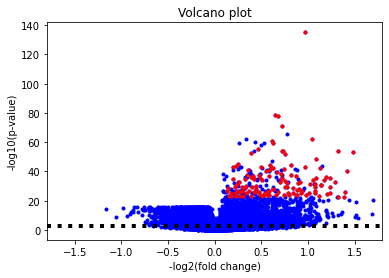



Nombre de gène significatifs combinés pour melanoma: 455
LISTE FINALE DE GENES POUR melanoma:
'LARP1B' 'TMEM201' 'NRP2' 'SASH1' 'MYO5A' 'PSME1' 'RAB38' 'IL15' 'RASSF7'
 'ANKRD39' 'SIRPA' 'SIRPA' 'SPRYD4' 'SDC3' 'SRPX' 'TAOK3' 'RABGAP1'
 'RAB40C' 'DDT' 'AA046941' 'LINC00622' 'HMG20B' 'TMEM117' 'QDPR' 'C1orf43'
 'RHOJ' 'RHOJ' 'LARP1B' 'FMN2' 'ST3GAL6' 'HMCN1' 'ASS1' 'TUBD1' 'GPM6B'
 'GPM6B' 'GPM6B' 'GPM6B' 'MYO5A' 'AI446064' 'RTN3' 'PDE4B' 'FAM167B'
 'PLEKHH1' 'FBXO22' 'FBXO22' 'NUCB2' 'INADL' 'SMUG1' 'FAM210A' 'HOXD8'
 'GNPTAB' 'SLC45A2' 'CITED1' 'SAMD4A' 'STEAP1B' 'SLC23A2' 'RBM19'
 'LOC152225' 'CORO1C' 'HNRNPH1' 'TTYH2' 'ARMC9' 'MAD2L1BP' 'AK024681'
 'SNCA' 'HPS4' 'TMEM87A' 'QPCT' 'N20927' 'MITF' 'CHST6' 'MCOLN2' 'NRP2'
 'FMN2' 'SSH1' 'SGCD' 'PTPMT1' 'LINC00327' 'SLC35B4' 'TYR' 'TYR'
 'TNFRSF14' 'IL1RAP' 'ECM1' 'GPNMB' 'SH2D4A' 'AARS2' 'AW138801' 'PWWP2B'
 'SNCA' 'UPP1' 'SOX5' 'SSH1' 'PHACTR1' 'HDAC8' 'SLC23A2' 'VEPH1' 'IL15RA'
 'ZNF106' 'S100A1' 'DCT' 'DCT' 'MCOLN2' 'AP1S2' 'AP1S2'

C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


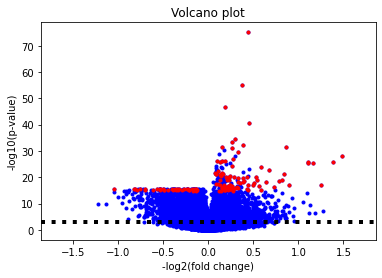



Nombre de gène significatifs combinés pour breast: 60
LISTE FINALE DE GENES POUR breast:
'SLC44A2' 'SCAMP1' 'SLC2A4RG' 'PTGER4' 'MTFMT' 'VPS13B' 'LOC100506130'
 'MTRF1' 'EIF3J' 'SEC31A' 'YIPF3' 'CHD9' 'TP53' 'CRBN' 'RGS14' 'HMGN5'
 'HMG20A' 'PDS5B' 'SNX5' 'AW291485' 'ZNF625' 'ETNK1' 'CIAPIN1' 'PITX1'
 'BACE1' 'AA732944' 'SLC2A4RG' 'MDH1' 'NIPA2' 'VPS28' 'DERL1' 'BACE1'
 'RAF1' 'ZNF558' 'SLC44A2' 'ZNF83' 'PBX1' 'ADORA1' 'ZFYVE20' 'CIAPIN1'
 'NRG2' 'AI653381' 'OGFOD3' 'BACE1' 'ZNF548' 'ZNF280B' 'LINC00663' 'BTBD1'
 'PPP1R13L' 'ATP8B1' 'EMC2' 'TLE6' 'ZNF280B' 'AW664026' 'SCAMP1'
 '217329_x_at' 'TRIM5' 'ARHGAP35' 'BACE1' 'DDAH2'


C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)


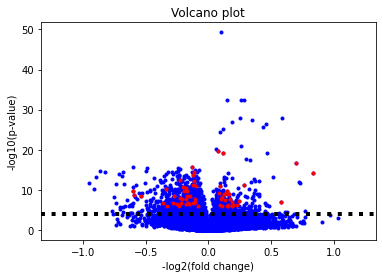



Nombre de gène significatifs combinés pour ovarian: 145
LISTE FINALE DE GENES POUR ovarian:
'SURF4' 'PAX8' 'WBSCR16' 'LPHN2' 'FAM63B' 'PAX8' 'EPCAM' 'TMEM199' 'UTY'
 'EIF1AY' 'GTF3A' 'SRGAP2' 'MBIP' 'OTUB1' 'VPS33B' 'CAMSAP3' 'FOLR1'
 'PAG1' 'ZSCAN31' 'TAOK3' 'GDA' 'SHOX2' 'ELOVL7' 'STAT1' 'LMAN1' 'NOSIP'
 'GYPC' 'STAMBPL1' 'TMEM158' 'DDX3Y' 'EZR' 'EZR' 'KTN1' 'VPS33B' 'SPINT2'
 'EPB41L4A' 'SLC2A14' 'SIX4' 'SFMBT1' 'TMEM139' 'ZBTB1' 'PLCD3' 'TMEM248'
 'ANKRD28' 'AMOTL2' 'SLC2A3' 'FLJ22184' 'QPRT' 'SLPI' 'KLF5' 'GDA' 'RECQL'
 'RECQL' 'RECQL' 'TBC1D8B' 'BMS1P20' 'CHMP4C' 'BCAT2' 'ECI1' 'HOOK1'
 'ARHGEF28' 'SFN' 'C12orf66' 'ZBED9' '242201_at' 'SNX24' 'RAP2B' 'TGFBR1'
 'MDFIC' 'PKP2' 'RBMS2' 'STK10' 'WWC2' 'PAX8' 'FSTL1' 'SHROOM3' 'AI769673'
 'C12orf66' 'HENMT1' 'FBXO32' 'TOB2' 'TRIM14' 'SLC35F5' 'RABEP1' 'DIEXF'
 'DSP' 'RBMS2' 'EVI5L' 'RAB27A' 'SNX24' 'DMKN' 'TAOK3' 'BEX2' 'PDGFC'
 'ITPR1' 'STAT1' 'STAT1' 'STAT1' 'FAM89A' 'WWOX' 'IL18' 'TBC1D8B' 'EGR1'
 'AI829721' 'SMPDL3A' 'TSPAN12' 'D

C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


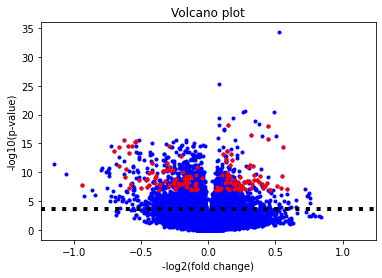



Nombre de gène significatifs combinés pour colon: 377
LISTE FINALE DE GENES POUR colon:
'RPL21P28' 'SPATA13' 'ESRP2' 'ESRRA' 'LPHN2' 'EPS8L3' 'AW003893' 'PXK'
 'PXK' 'RASSF7' 'FA2H' 'MAP7' 'MAP7' 'QKI' 'SALL2' 'USH1C' 'MPDZ' 'EHF'
 'C1orf116' 'L3HYPDH' 'HCFC2' 'LINC00478' 'ITGB4' 'ITGB4' 'SRGAP2'
 'AW665279' 'TP73-AS1' 'HNRNPD' 'BCAN' 'BCAN' 'ANO1' 'MARVELD2' 'GNB4'
 'IRF6' 'IRF6' 'A1BG' 'PALD1' 'ITPR1' 'MAP7' 'RASSF8' 'TRIM10' 'ANXA6'
 'MPDZ' 'FERMT2' 'KLF5' 'KLF5' 'FERMT2' 'PRSS3' 'TMC5' 'SLC26A2' 'TUSC3'
 '221648_s_at' 'OR7E14P' 'ZNF570' 'ARHGEF10L' 'ZNF256' 'SH3D19' 'MACC1'
 'MACC1' 'JAZF1' 'JAZF1' 'LRP12' 'USH1C' 'KDF1' 'SYK' 'FAM229B' 'RAB6A'
 'RAB6A' 'TMEM125' 'C20orf194' 'FGF19' 'ESRP1' 'BCLAF1' 'CHDH' 'PLS1'
 'C9orf152' 'SLC35A2' 'TIMP2' 'LOC339803' 'LOC339803' 'CDH1' 'GPNMB'
 'DOCK6' 'TIMP3' 'TIMP3' 'TIMP3' 'TIMP3' 'BMP4' 'CUX1' 'RASSF8'
 'LOC100509683' 'TMC5' 'RAB34' 'HDAC1' 'ZNF512B' '232150_at' 'MACC1'
 'LAD1' 'TRAK1' 'EHF' 'COMMD1' 'C1orf116' 'AKR1B1' 'ZNF599' 'SLTM'
 '

C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


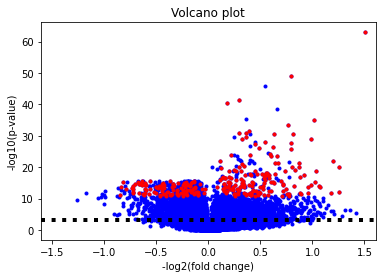



Nombre de gène significatifs combinés pour renal: 327
LISTE FINALE DE GENES POUR renal:
'ZNF462' 'TFPI' 'FGD6' 'H2AFZ' 'CIPC' 'ZBTB4' 'ZNF326' 'GLS' 'PPP2R5C'
 'SHANK2' 'SHANK2' 'C6orf203' 'EPAS1' 'CASK' 'TOR3A' 'GGCT' 'PALLD'
 'SYNPO' 'AA227879' 'PALLD' 'HAVCR1' 'NMT2' 'NMT2' 'ATAD3B' 'PHLDB2'
 'MTCL1' 'KRT80' 'KCNMA1' 'LOXL2' 'NME7' 'RAB11FIP4' 'NXPE3' '229859_at'
 'CEP85' 'TUSC3' 'TSPAN33' 'PAPSS2' 'PAPSS2' 'PAPSS2' 'KIAA1731' 'CEP85'
 'CAV1' 'MYO1E' 'TMEFF1' 'PDZK1IP1' 'PFKP' 'DUSP1' 'TGM2' 'DUSP1' 'TNIP1'
 'CGNL1' 'CD40' 'CES2' 'ZNF324' 'SLC41A2' 'SLC35F5' 'SHISA9' 'UGCG'
 'LOC339803' 'CITED2' 'EPM2A' 'RTN4' 'LRP8' 'CYP39A1' 'BRE' 'CNDP2' 'TGM2'
 'TBC1D12' 'AU147419' 'OSGEP' 'TOMM5' 'YPEL5' 'TRPC1' 'SERTAD4-AS1'
 'USP31' 'PPARGC1B' 'CAV2' 'CAV2' 'ATRIP' 'ELFN2' 'TGFB2' 'PSD3' 'FGD6'
 'DCBLD2' 'FOSL2' 'RUNX2' 'AP1B1' 'BG165613' 'ZNF589' 'ARSJ' 'ADORA1'
 'RBMS3' 'APBB1IP' 'PPP2R3A' 'PPP2R3A' 'PML' 'AUNIP' 'FMNL2' 'DCBLD2'
 'CES2' 'TFPI' 'LRRN4' 'LRRN4' 'FAM49A' 'BRE' 'ITGA3' 'MOXD

C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:102: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc),-np.log10(p),'b.',zorder=0)
C:\Users\simon\Desktop\HEIG\S6\BBC\Projet\stats.py:110: RuntimeWarning: divide by zero encountered in log10
  plt.plot(-np.log2(fc[idx]),-np.log10(p[idx]),'r.',zorder=1)


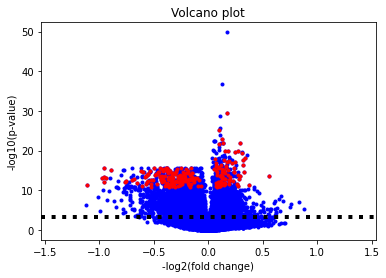

In [77]:
idx_sg_finals = {}

for disease in diseases:
    
    # keep only genes that appear significantly in each t-test AND in the correlation test
    idx_sg_finals[disease] = np.array( list( set(idx_sg_ttests[disease]) & set(idx_sg_corrs[disease]) ) )
    
    print(f'Nombre de gène significatifs combinés pour {disease}: {len(idx_sg_finals[disease])}')
    print(f'LISTE FINALE DE GENES POUR {disease}:\n'+str(data_train[idx_sg_finals[disease]+1,1]).strip('[]'))
    stats.volcano_plot(data_train[1:,2:],desired_profiles[disease],idx=idx_sg_finals[disease], pval=pval_correls[disease])
    print("\n")

On a diviser à peu près par 2 le nombre de gènes

Création d'un seul set contenant toute la liste des gènes signficatifs

In [78]:
idx_genes_final = set()
for disease in diseases:
    for gene in idx_sg_finals[disease]:
        idx_genes_final.add(gene)
idx_genes_final = np.array(list(idx_genes_final))
    
print(f'Nombre de gène significatifs : {len(idx_genes_final)}')
print(f'LISTE FINALE DE GENES :\n'+str(data_train[idx_genes_final+1,1]).strip('[]'))

Nombre de gène significatifs : 1998
LISTE FINALE DE GENES :
'PHTF1' 'PAX8' 'PGAP2' ... 'CALML4' 'GNB4' 'GNB4'


18'500 / 54'000 ca fait un peu beaucoup

# Création classificateur
Maintenant que les gènes ont été sélectionnés, on fait 9 classificateurs k-nearest neighbors pour chaque cancer.

In [79]:
from sklearn import neighbors

def kNN_classifier(X, y, X_test, y_test):
    # train de SVM classifier
    clf = neighbors.KNeighborsClassifier()
    clf.fit(X, y)

    # return score
    score = clf.score(X_test,y_test)
    return score

In [80]:
print("{: >20} {: >20}".format("Cancer location", '% prédictions'))
print('------------------------------------------------------------------')
for disease in diseases:
    # train set
    X = data_train[idx_genes_final+1,2:]
    # il faut transposer la matrice, car SVM s'attend a recevoir les features en colonnes et non en lignes
    X = np.transpose(X)
    X = np.array(X,dtype=float)
    y = [1 if id_cond_tissue[s] == disease else 0 for s in data_train[0,2:]]

    # test set
    X_test = data_test[idx_genes_final+1,2:]
    X_test = np.transpose(X_test)
    X_test = np.array(X_test,dtype=float)
    y_test = [1 if id_cond_tissue[s] == disease else 0 for s in data_test[0,2:]]
    score = kNN_classifier(X, y, X_test, y_test)
    print("{: >20} {: >20}".format(disease, str(round(100*score))))

     Cancer location        % prédictions
------------------------------------------------------------------
            prostate                  100
 non-small cell lung                   97
                 CNS                  100
            leukemia                  100
            melanoma                  100
              breast                   97
             ovarian                   97
               colon                  100
               renal                  100


Les scores de performances de nos classificateurs avec nos données de test sont très encourageantes (tous parfait).
